# overall workflow

## data acquisition
We scrape data from Tagesspiegel, a Berlin based newspaper covering local, national and international topics.

In [1]:
from datetime import date
from data_acquisition import scrape_tsp as st

In [2]:
str(date.today())

'2020-09-09'

In [3]:
st.get_links()

<Response [200]>


'wrote 170 links to data_acquisition/links-tsp-2020-09-09.txt'

In [5]:
scraped_file = 'data_acquisition/links-tsp-' + str(date.today()) + '.txt'
st.select_new_links(scraped_file)

Before running the next cell, update the integer number in st.get_content( .. , int , ...)

Should be updated to the numer that was returned the last time the cell ran.

In [6]:
#%run 'data-acquisition/get-content-02.py'
#from data_acquisition import get_content_tsp_03

import os

path_to_link_file= 'data_acquisition/links-tsp-'+str(date.today())+'-new.txt'
path_to_output_folder='tagesspiegel-'+str(date.today())

_, dirs, _ = next(os.walk(os.getcwd()))

if path_to_output_folder in dirs:
    print("** folder exists **")
else:
    os.mkdir(path_to_output_folder, mode=0o744) 

#print(path_to_output_folder)
st.get_content(path_to_link_file,1382,path_to_output_folder)

1511

When articles are downloaded, add new links to 'bestand'
in unix: cat file_with_new_links >> bestands_file

In [ ]:
# use cat in unix or copy paste by hand

## data cleaning
 1. We check for advertisement in the articles' text. Ad text is included in brackets [...]
 2. We check for empty authors. 
 3. We check for missing date of publication
 4. We check for press releases
 5. remove content from plus.tagesspiegel.de (advertising, infotainment, Kundenbindung)
 
ad 2: An empty list of authors is replaced by the name of the paper: Tagesspiegel.

ad 4: An article that is a press release has closing characters (tsp) or (tsp,dpa) or similar. We remove the parenthesis and the enclosed text.

In [7]:
from data_cleaning import clean_tsp as ct

In [8]:
ct.clean_up('tagesspiegel-2020-09-09','2020-09-09')

{'files inspected': 0,
 'files with ads': 63,
 'ads removed': 96,
 'files not clean': 8,
 'files bot clean reasons': ['too short',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)'],
 'dates imputed': 0}

In [5]:
ct.clean_up('tagesspiegel-2020-08-02','2020-08-02')

tagesspiegel-2020-08-02/00843.json
tagesspiegel-2020-08-02/00859.json
tagesspiegel-2020-08-02/00878.json
tagesspiegel-2020-08-02/00840.json


{'files inspected': 78,
 'files with ads': 43,
 'ads removed': 64,
 'files removed': 4,
 'files removed reasons': ['wrong type: author',
  'wrong type: imagegallery',
  'too short',
  'too short'],
 'dates imputed': 6}

In [3]:
ct.clean_up('tagesspiegel-2020-09-04','2020-09-04')

tagesspiegel-2020-09-04/01126.json
tagesspiegel-2020-09-04/01045.json
tagesspiegel-2020-09-04/01048.json


{'files inspected': 138,
 'files with ads': 61,
 'ads removed': 81,
 'files removed': 3,
 'files removed reasons': ['wrong type: imagegallery',
  'wrong type: imagegallery',
  'wrong type: imagegallery'],
 'dates imputed': 9}

In [4]:
ct.clean_up('tagesspiegel-2020-08-04','2020-08-04')

tagesspiegel-2020-08-04/00973.json
tagesspiegel-2020-08-04/01016.json
tagesspiegel-2020-08-04/00914.json


{'files inspected': 118,
 'files with ads': 60,
 'ads removed': 74,
 'files removed': 3,
 'files removed reasons': ['too short',
  'wrong type: imagegallery',
  'too short'],
 'dates imputed': 6}

In [8]:
ct.clean_up('tagesspiegel-2020-09-05','2020-09-05')

tagesspiegel-2020-09-05/01239.json


{'files inspected': 89,
 'files with ads': 40,
 'ads removed': 51,
 'files removed': 1,
 'files removed reasons': ['too short'],
 'dates imputed': 7}

## ml task

In [5]:
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

import re

from textblob_de import TextBlobDE 

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import math

import json


def preprocess(text):
    #print(text)
    a = text.lower() # lower cases only
    b = re.sub("(\\W|\\d)"," ",a) #remove non-ascii and digits
    blob = TextBlobDE(b)
    return(blob.words.lemmatize()) # lemmatize for german


def read_articles_transform_to_df (path_to_text_files='../tagesspiegel/*.txt', debug=False):

	file_list=glob.glob(path_to_text_files)
	#file_list = glob.glob("../tagesspiegel/*.txt")
	#print(file_list)

	n = len(file_list)
	print(n , "files to work with.")
	if debug==True:
		n_restrict = 10
		print('debug mode, working with a subset of ' + str(n_restrict) + ' files.')
		n = n_restrict
        
	#list_of_articles = []
	X = pd.DataFrame(columns=['file','title','text','description','date','image'])

	for i in range(n):
		#print(i, ' of ', n)
		with open (file_list[i]) as file:
			article = json.loads(file.read())
			print(file_list[i])
			X=X.append({'file':file_list[i] , 'text':article['text'], 'title':article['title'], 'description':article['description'], 'date':article['publish-date'], 'image':article['image']}, ignore_index=True)
	#print(X.shape)
	return(X)

def enthropy(pv):
	# should check, that all values are positive and sum to (about) 1
	return(-sum([pv[i]*math.log(pv[i]) for i in range(len(pv))]))

def evaluate_cluster(km_object):
	n, bins, patches = plt.hist(km_object.labels_, km_object.n_clusters, facecolor='blue', alpha=0.5)
	plt.title('sizes of clusters')
	plt.ylabel('nr. of articles')
	plt.show()

	rel_fq = [round(ni/sum(n),3) for ni in n] 
#		print('elements in bins: ' , n)
#		print('relative size of bins: ', rel_fq)
#		print('enthropy: ', enthropy(rel_fq))

	return({'n': n , 'frequencies': rel_fq , 'enthropy': enthropy(rel_fq), 'inertia':km_object.inertia_})

preprocessing does some basic transfomation of a text into a wordlist:

Remove non ascii symbols and numbers / digits.

Remove punctuation. Lemmatize.

In [51]:
preprocess('Ich, meiner, mir, mich. Hallo hier ist ein Baum. %§/$. Oder 8 oder 9 oder 77 bzw. zwölf?? Läuft lief gelaufen')

WordList(['ich', 'meinern', 'mir', 'mich', 'hallo', 'hier', 'sein', 'ein', 'baum', 'oder', 'oder', 'oder', 'bzw', 'zwölf', 'laufen', 'laufen', 'laufen'])

In [6]:
X = read_articles_transform_to_df('tagesspiegel_01/*clean.json',debug=True)
#X['text'][0] # to check what we work with: Umlaute are correct, Data cleaning should have removed advertising text ...

736 files to work with.
debug mode, working with a subset of 10 files.
tagesspiegel_01/00946-clean.json


KeyError: 'image'

In [76]:
preprocess(X.iloc[8]['title'])

WordList(['Schüler', 'in', 'nrw', 'müssen', 'auch', 'im', 'unterricht', 'maske', 'tragen'])

In [55]:
type(X) , X.shape
X['title'].head

<bound method NDFrame.head of 0                                         Der Tonretter
1            Leugnen, Kleinreden, Verschwörungstheorien
2     Der Schmerzensmann – zum Tod des Schauspielers...
3     Polizeipräsidentin verurteilt „martialische“ S...
4     Mit Index.hu ist „Ungarns Startseite“ dem Syst...
5     Die Fachbegriffe der Corona-Pandemie und was s...
6     Wie eine Krankheit meine Freundin verschwinden...
7     Hertha-Investor Lars Windhorst lässt nicht locker
8     Schüler in NRW müssen auch im Unterricht Maske...
9     Weltmeister André Schürrle beendet mit nur 29 ...
10                          Dating-Seiten im Überblick*
11         Hertha BSC und die Probleme in der Offensive
12            Die kulinarischen Höhepunkte im September
13    Streit übers Klima stürzt Berliner Koalition i...
14             Warum Jörg Sartor die SPD aufgegeben hat
15    Als nächstes möchten sie das Grundgesetz absch...
16    „Der Brand in Moria ist eine Katastrophe mit A...
17    Bushido verg

In [58]:
[' '.join(preprocess(t)) for t in X['title']]

['der tonretter',
 'leugnen kleinred verschwörungstheorien',
 'der schmerzensmann zum tod des schauspielers birol ünel',
 'polizeipräsidentin verurteilt martialisch sprüche bei aufnahmeritual',
 'mit index hu sein ungarns startseite dem system orbán zum opfer gefallen',
 'die fachbegriffe der corona pandemie und was sie bedeuten',
 'wie ein krankheit meine freundin verschwinden lassen',
 'hertha investor lars windhorst lassen nicht lock',
 'Schüler in nrw müssen auch im unterricht maske tragen',
 'weltmeister andré schürrle beendet mit nur jahren seine karriere',
 'dating seiten im überblick',
 'hertha bsc und die probleme in der offensive',
 'die kulinarisch höhepunkte im september',
 'streit übers klima stürzt berlin koalition in die krise',
 'warum jörg sartor die spd aufgeben haben',
 'als nächst möcht sie das grundgesetz abschaffen',
 'der brand in moria sein ein katastrophe mit ansage',
 'bushido vergleichen beziehung zu clanchef abou chaker mit zwangsheirat',
 'Seehofer gegen na

In [79]:
list_of_titles = [' '.join(preprocess(t)) for t in X['title']]
print(list_of_titles)

cv = TfidfVectorizer(max_df=0.8 , min_df =2)
#print('cv: ' , dir(cv))
km =  KMeans(init='k-means++', n_clusters=5, n_init=10)

text_cluster = Pipeline([('vect', cv), ('cluster', km) ])

#text_cluster.fit(list_of_titles[0:100])
text_cluster.fit(list_of_titles)

#labels_as_column = pd.DataFrame(km.labels_)
#print(type(labels_as_column), labels_as_column.shape)

X['cluster'] = pd.DataFrame(km.labels_) # contains labels
#print(X)

['der tonretter', 'leugnen kleinred verschwörungstheorien', 'der schmerzensmann zum tod des schauspielers birol ünel', 'polizeipräsidentin verurteilt martialisch sprüche bei aufnahmeritual', 'mit index hu sein ungarns startseite dem system orbán zum opfer gefallen', 'die fachbegriffe der corona pandemie und was sie bedeuten', 'wie ein krankheit meine freundin verschwinden lassen', 'hertha investor lars windhorst lassen nicht lock', 'Schüler in nrw müssen auch im unterricht maske tragen', 'weltmeister andré schürrle beendet mit nur jahren seine karriere', 'dating seiten im überblick', 'hertha bsc und die probleme in der offensive', 'die kulinarisch höhepunkte im september', 'streit übers klima stürzt berlin koalition in die krise', 'warum jörg sartor die spd aufgeben haben', 'als nächst möcht sie das grundgesetz abschaffen', 'der brand in moria sein ein katastrophe mit ansage', 'bushido vergleichen beziehung zu clanchef abou chaker mit zwangsheirat', 'Seehofer gegen national alleingänge

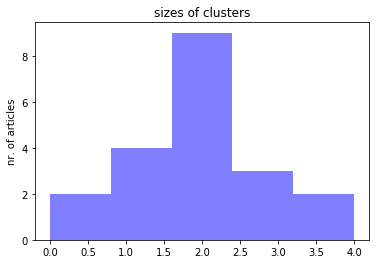

{'n': array([2., 4., 9., 3., 2.]),
 'frequencies': [0.1, 0.2, 0.45, 0.15, 0.1],
 'enthropy': 1.4263010621165084,
 'inertia': 7.69579025609874}

In [61]:
evaluate_cluster(km)
#cv.get_feature_names()[0:10]

## Word cloud representation for cluster

Collect all text from a specified cluster and create its wordcloud.

Some stopwords are features.

In [114]:
my_stopper = ['nur','sein','seine','deine','meine','am','sie','bei','durch','noch','sich','in','im','ihr','ihre','vor','zur','seit','es','zu','werden','haben','sein','von','jedoch','auch','des','dies','als','wie','dem','den','um','mit','sein','auf','der','die','das','und','ein','aus','kein','wir','ihr','er','dass','du','ich','mein','mich','dein','dir','dich']
'meine' in my_stopper
# [w in cv.get_feature_names() for w in my_stopper]

True

For each cluster save the articles belonging to the cluster in a csv file.

For each cluster create a wordcloud from all article titles to represent the cluster.


In [116]:
#!pip install wordcloud

K=km.n_clusters
for k in range(K):
    Xcl = X.loc[X['cluster']==k]
    
    # write articles in this cluster to csv file
    ## needed later to display headlines and text from the (externally running) Flask server
    
    filename = 'article_clustered'+str(k)+'.csv'
    Xcl.to_csv(filename, sep=';', encoding='utf-8', header=True)
    
    # all words of all titles in one string, preprocessed and without stopp words
    t1 = [' '.join(preprocess(t)) for t in Xcl['title']]
    t2 = ' '.join(t1)
    text = [w for w in t2.split() if w not in my_stopper]
    
    wordcloud = WordCloud().generate(' '.join(text))
    wordcloud.to_file('cluster'+str(k)+'.png')

## presentation as html , website

* call an external python script to start the server (Flask)
* go to 127.0.0.0:5005 to interact with the website

,file,text,headline,cluster
0,tagesspiegel_01/00946-clean.json,dass australien heuen ein weinexportnation sei...,Der Tonretter,4
1,tagesspiegel_01/00971-clean.json,am sonntag versprüht zum ersen mal ein lastwag...,"Leugnen, Kleinreden, Verschwörungstheorien",1
2,tagesspiegel_01/01081-clean.json,er machen ein angst und bange so wie er sich v...,Der Schmerzensmann – zum Tod des Schauspielers...,3
3,tagesspiegel_01/00782-clean.json,die berliner polizei müssen sich erneuen mit f...,Polizeipräsidentin verurteilt „martialische“ S...,4
4,tagesspiegel_01/00852-clean.json,es sein ein stumm prozession nur das geschnatt...,Mit Index.hu ist „Ungarns Startseite“ dem Syst...,1
5,tagesspiegel_01/00696-clean.json,auf der pressekonferenz des robert koch instit...,Die Fachbegriffe der Corona-Pandemie und was s...,1
6,tagesspiegel_01/00865-clean.json,meinen freundin sein verschwund seit monaten z...,Wie eine Krankheit meine Freundin verschwinden...,1
7,tagesspiegel_01/00924-clean.json,immer wieder lars windhorst der hertha investo...,Hertha-Investor Lars Windhorst lässt nicht locker,2
8,tagesspiegel_01/00913-clean.json,Nordrhein westfal führen ein weitgehend masken...,Schüler in NRW müssen auch im Unterricht Maske...,0
9,tagesspiegel_01/00830-clean.json,andré schürrle reden offen über einsamkeit übe...,Weltmeister André Schürrle beendet mit nur 29 ...,2
